<a href="https://colab.research.google.com/github/ecandes/stat318/blob/master/Coupling_from_the_Past.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structured Project (Brian Lui)

# Question 1

# 1(a): Implment the Propp-Wilson algorithm for the Ising Model

Imagine we have a Markov chain that we decide to write as 

$$
X_t = f(X_{t-1}, \theta_t).
$$

Below, we will write $f_\theta$ as a shorthand for $f(\cdot, \theta)$ so that we have 

$$
X_t = f_{\theta_t}(X_{t-1})
$$

and, therefore, 

$$
X_t = f_{\theta_t} \circ \ldots \circ f_{\theta_1}(X_0).
$$

### Contraction to a constant mapping

One key idea is that time-reversing leads to the same distribution: that is, if we set 

$$
Y_t =  f_{\theta_1} \circ \ldots \circ f_{\theta_t}(X_0), 
$$ 

then 
$$
X_t \stackrel{d}{=} Y_t.
$$

Having said this, there is a profound difference between $Y_t$ and $X_t$. Indeed, consider the map 

$$
D_t = f_{\theta_1} \circ \ldots \circ f_{\theta_t},
$$

In fact, there is a random time $T$ at which $D_T$ becomes constant. It is clear that for all $t \ge T$, $D_t$ does not move, i.e., $D_t$ is equal to this constant mapping. 

This has an importance consequence. If the Markov chain converges to a stationary distribution in the sense that 

$$
\lim_{t \rightarrow \infty} \mathcal{L}(X_t) = \pi,
$$ 

then we can see that 

$$
\pi = \lim_{t \rightarrow \infty}  \mathcal{L}(Y_t) = \mathcal{L}(Y_T). 
$$

In other words, $Y_T$ is a *perfect* sample from $\pi$. 

### Ordering

We would need to track when the mapping becomes constant. To do this, we might imagine that we would have to track many trajectories but in some situations this is not the case. There sometimes is a monotonicity property, which lets us track only a small number of states. In the best possible scenario, we would only track a minimal and a maximal state and stop when 

$$
D_t(X_{\text{min}}) = D_t(X_{\text{max}}).
$$

In the case of the Ising model, the two states are all spins down and all spins up. 

The monotonicity property states that for all states $X$ such that 

$$
X_{\text{min}} \le X \le X_{\text{max}}
$$

we have that 

$$
D_t(X_{\text{min}}) \le D_t(X) \le D_t(X_{\text{max}}). 
$$

This is typically proven by induction on $t$. 




## Ising model 

A configuration $x \in \{\pm1\}^{d_1 \times d_2}$ follows the Ising model if the density is of the form 

$$
\pi(I) \propto e^{-\beta E(x)}, 
$$

where the energy is defined as

$$
E(I) = - \sum_{v \sim v'} x_v x_{v'};
$$

above, the sum is taken over the edges of a graph, which we will take as the square lattice. The parameter $\beta$ is an inverse temperature parameter. The larger $\beta$ (the lower the temperature), the stronger the alignment. 

There is a famous critical temperature given by 

$$
\beta_c = \log(\sqrt{2} + 1)/2 \approx 0.44. 
$$

We want to simulate Ising models at warmer temperatures, i.e. for values of $\beta$ obeying $\beta < \beta_c$. 

In [8]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [9]:
class IsingModel:

    def __init__(self, G):
        self.G = G                   # Underlying graph
        self.n = G.number_of_nodes()  # Number of nodes
        self.nodes = list(G.nodes.keys())  # List of nodes
        self.nodes_tolist = dict(zip(self.nodes,range(self.n)))
        self.Xmax =  np.ones(self.n,dtype=int)
        self.Xmin = -np.ones(self.n,dtype=int)
        # Useful for plotting
        self.pos = dict(zip(self.nodes, self.nodes))

    def getNeighbors(self,v):
        return [self.nodes_tolist[w] for w in self.G.neighbors(self.nodes[v])]

    def sumNeighbors(self, X, v):
        return np.array([X[w] for w in self.getNeighbors(v)]).sum()

    def GibbsUpdate(self,X,v,theta,beta):
        prob =  1/(1 + np.exp(-2*beta*self.sumNeighbors(X,v))) 
        X[v] = 1 if theta < prob else -1

    def ProppWilson(self,beta):
      
        def updateSites(siteList,nsteps):
            new_list = np.random.choice(self.n, nsteps, replace=True)
            siteList.extend(new_list)
        
        def updateThetas(thetaList,nsteps):
            thetaList.extend(list(np.random.rand(nsteps)))
        
        nsteps = 1
        siteList, thetaList = [], []

        print('Steps: ', end = " ")
        while not np.array_equal(self.Xmax, self.Xmin):
            print(int(np.log2(nsteps)), end = " ")
            # Sample new vertices that will be updated  
            updateSites(siteList,nsteps)
            # Toss new coins to flip signs 
            updateThetas(thetaList,nsteps)
            # Perform Gibbs update 
            for site, theta in zip(siteList[::-1],thetaList[::-1]):
                self.GibbsUpdate(self.Xmax,site,theta,beta)
                self.GibbsUpdate(self.Xmin,site,theta,beta)

            nsteps *= 2 
    
    def drawConfig(self, X, **options):
        up =   [self.nodes[v] for v in range(self.n) if X[v] ==  1]
        down = [self.nodes[v] for v in range(self.n) if X[v] == -1] 
        nx.draw(G, self.pos, nodelist=up, node_color="b", **options)
        nx.draw(G, self.pos, nodelist=down, node_color="r", **options)
        plt.title('Ising model configuration')
        plt.show()


In [94]:
L = 10
G = nx.grid_2d_graph(L,L)
chain = IsingModel(G)
beta = 0.2
# plt.rcParams["figure.figsize"] = (4,4)
chain.ProppWilson(beta)

Steps:  0 1 2 3 4 5 6 7 8 9 10 

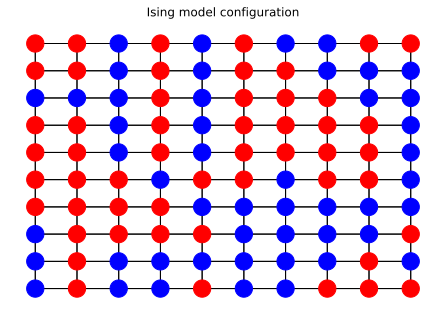

In [95]:
chain.drawConfig(chain.Xmin)

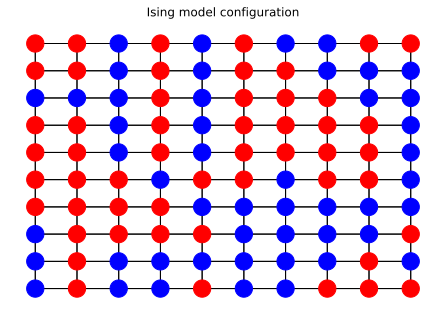

In [96]:
chain.drawConfig(chain.Xmax)

In [97]:
%%time
L = 100
G = nx.grid_2d_graph(L,L)
chain = IsingModel(G)
beta = 0.2
# plt.rcParams["figure.figsize"] = (4,4)
chain.ProppWilson(beta)

Steps:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 CPU times: user 13.9 s, sys: 109 ms, total: 14 s
Wall time: 14.9 s


In [98]:
fig = plt.figure()
fig.set_figheight(6) 
fig.set_figwidth(6)
options = {'node_size' : 8, 'width' : 1}
chain.drawConfig(chain.Xmin,**options)

# 1(b): Expected running time

We refer to the proof of Part (i) of the theorem on Page 35 of Lecture 16 posted on Canvas.  Since $G$ in our problem is an $n \times n$ square lattice, the maximum degree of vertices is $\Delta = 4$.  Let $c(\beta) := 1 - \Delta \tanh(\beta) = 1 - 4 \tanh(\beta)$.  If $4 \tanh(\beta) < 1$, then $c(\beta) > 0$, so by the proof of Part (i), we have
\begin{align}
    \mathbb{E}[X_t(X_{\mathrm{min}}), X_t(X_{\mathrm{max}})]
    &\leq |V| e^{-c(\beta) t / |V|} \\
    &= n^2 e^{-c(\beta) t / n^2} \\
\end{align}
where $X_t = f_{\theta_t} \circ \cdots \circ f_{\theta_1}$.

Let $\rho$ denote the Hamming distance defined in Lecture 16.

The, the expected time of coalesce $\mathbb{E}[\tau]$ is
\begin{align}
    \mathbb{E}[\tau]
    &= \sum_{t=0}^\infty \mathbb{P}(\tau \geq t) \\
    &= \sum_{t=0}^\infty \mathbb{P}(\rho(D_t(X_{\mathrm{min}}), D_t(X_{\mathrm{min}})) \geq 1) \\
    &= \sum_{t=0}^\infty \mathbb{P}(\rho(X_t(X_{\mathrm{min}}), X_t(X_{\mathrm{min}})) \geq 1) \text{ since $X_t$ and $D_t$ are identically distributed}\\
    &\leq \sum_{t=0}^\infty \mathbb{E}[\rho(X_t(X_{\mathrm{min}}), X_t(X_{\mathrm{min}}))] \text{ by Markov's inequality} \\
    &\leq \sum_{t=0}^\infty n^2 e^{-c(\beta) t / n^2} \\
    &= \frac{n^2}{1 - e^{-c(\beta) / n^2}}
\end{align}
by the geometric series formula.  Therefore, if $4 \tanh(\beta) < 1$, the theoretical upper bound on the expected running time is 
\begin{align}
    \frac{n^2}{1 - e^{-c(\beta) / n^2}} 
    &= \frac{n^2}{1 - e^{-(1 - 4 \tanh(\beta)) / n^2}}.
\end{align}

### What do I observe in practice...

In [120]:
L = 100
beta = 0.2
c_beta = 1 - 4 * np.tanh(beta)
assert c_beta > 0
upper_bound = L**2 / (1 - np.exp(-c_beta / (L**2)))
upper_bound

475067273.20914656

Suppose $G$ is a $100 \times 100$ square lattice.  When $\beta = 0.2$ above, which satisfies $4 \tanh(\beta) < 1$, we saw the actual algorithm takes somewhere between $2^{16} = 65536$ and $2^{17} = 131072$ steps only to converge, much lower than the theoretical upper bound of around 475,067,273 steps.

# Question 2

When $\beta >> \beta_c$, the temperature $T = 1/\beta$ is much lower than the critical temperature $1/\beta_c = T_c$.  All the spins in the Ising then tend to be aligned with cooperative performance.  The single-site update of the Gibbs sampler for the Ising model slows down rapidly.  For example, we see that
\begin{align}
    \mathbb{P}(X_v = -1 | \text{ neighbors $ = +1$}) = \frac{1}{1 + e^{2 \beta g_v}} << 1
\end{align}
where $g_v = \sum_{v': v' \sim v} x_{v'}$.

With this critical slow down of the convergence of the Gibbs sampler at low temperatures when $\beta >> \beta_c$, the expected time of coalesce and hence expected running time is at least exponential in $|V| = n^2$.  No, our algorithm would not be practical at extremely low temperatures when $\beta >> \beta_c$.

# Question 3

We simplify the analysis of this problem by recognizing that the setting is similar to sampling with the Swendsen-Wang algorithm after the algorithm has converged.

Consider running the Swendsen-Wang algorithm on our graph $G$ with node variables $x_v$ and bond variables $b_e$ as described on Page 7 of Lecture 11 on Canvas, but just for one round after the algorithm has converged.  This train of thought inspires us to think of the following sampling methods:   
1. To get a cluster sample $A \sim \mu_p$ given an Ising sample $I \sim \pi_\beta$, for each edge $(u, v)$ on $G$ such $x_u = x_v$ in the Ising sample $I$, we independently include the edge into $A$ with probability $p = 1 - e^{-2 \beta}$.
1. To get an Ising sample $I \sim \pi_\beta$ given a cluster sample $A \sim \mu_p$, each cluster in $A$ takes on i.i.d. Bernoulli(1/2) values.

To justify our first procedure to get a cluster sample $A \sim \mu_p$ given an Ising sample $I \sim \pi_\beta$, we recognize that our procedure simply follows the Swendsen-Wang algorithm in sampling $\{b_e\}_{e \in E}$ conditional on the Ising sample $I = \{x_v\}_{v \in V}$.  Since the algorithm has already converged with $I \sim \pi_\beta$, we know that the cluster sample $A$ also follows the marginal distribution of $\{b_e\}_{e \in E}$ associated with the joint distribution given on Page 4 of Lecture 11:
\begin{align}
    \pi(x, b) \propto \prod_{e: x_v \neq x_{v'}} \mathbf{1}[b_e = 0] \prod_{e: x_v = x_{v'}} \left(\mathbf{1}[b_e = 0] + (e^{2\beta} - 1)\mathbf{1}[b_e = 1] \right)
\end{align}

Then, if we let $b_e = 1$ if $e \in A$ and $b_e = 0$ otherwise, the marginal distribution $A$ follows is
\begin{align}
    \pi(b)
    &= \sum_{x \in \{\pm 1\}^{|V|}} \pi(x, b) \\
    &\propto \sum_{x \in \{\pm 1\}^{|V|}} \prod_{e: x_v \neq x_{v'}} \mathbf{1}[b_e = 0] \prod_{e: x_v = x_{v'}} \left(\mathbf{1}[b_e = 0] + (e^{2\beta} - 1)\mathbf{1}[b_e = 1] \right) \\
    &\propto 2^{C(A)} 1^{|E| - |A|} (e^{2\beta} - 1)^{|A|} \text{ since the only contributions are from those with $b_e = 1 \implies x_v = x_{v'}$, } \\
    &\qquad \text{ i.e. each cluster has the same value, which has two choices, 1 and -1} \\
    &\propto 2^{C(A)} (e^{-2\beta})^{|E| - |A|} (1 - e^{-2\beta})^{|A|} \\
    &\propto 2^{C(A)} (1 - p)^{|E| - |A|} p^{|A|} \\
    &\propto \mu_p(A)
\end{align}
if we set $p = 1 - e^{-2\beta}$.

To justify our second procedure to get a Ising sample $I \sim \pi_\beta$ given a cluster sample $A \sim \mu_p$, we recognize that our procedure simply follows the Swendsen-Wang algorithm in sampling $\{x_v\}_{v \in V}$ conditional on the cluster sample $\{b_e\}_{e \in E}$ according to edge memberships in $A$ (i.e. $b_e = 1 \iff e \in A$.  Since the algorithm has already converged with $A \sim \mu_p$, as we showed above, we know that the Ising sample $I$ also follows the desired stationary distribution $\pi_{\beta}$, where $\beta$ satisfies $p = 1 - e^{-2 \beta}$.

Combining both analyses, we see that we have $p = 1 - e^{-2 \beta}$.

# Question 5

Sampling an Ising sample $I$ from $\pi_\beta$ on $G$ corresponding to sampling a cluster sample $A$ from $\mu_p$ on $G$ (Question 3) with $p = 1 - e^{-2\beta}$, which is equivalent to sampling another cluster sample $A^*$ from $\mu^*_{p^*}$ on $G^*$ (Question 4) with $p^* = 1 - p / (2-p)$, which is in turn equivalent to sampling another Ising sample $I^*$ from $\pi_{\beta^*}$ on $G^*$ with $p^* = 1 - e^{-2\beta^*}$.  Chaining these relationships together gives
\begin{align}
    p^* &= 1 - p / (2-p) \\
    1 - e^{-2\beta^*} &= 1 - \frac{1 - e^{-2\beta}}{1 + e^{-2\beta}} \\
    e^{-2\beta^*} &= \frac{1 - e^{-2\beta}}{1 + e^{-2\beta}} \\
    e^{-2\beta^*} &= \tanh(\beta)
\end{align}
as desired.

The fixed point of the equation happens when $\beta^* = \beta$, i.e.
\begin{align}
    e^{-2\beta} &= \tanh(\beta) \\
    e^{-2\beta} &= \frac{1 - e^{-2\beta}}{1 + e^{-2\beta}} \\
    (e^{-2\beta})^2 + 2e^{-2\beta} - 1 &= 0 \\
    e^{-2\beta} &= \frac{-2 \pm \sqrt{2^2 - 4(1)(-1)}}{2(1)} = -1 \pm \sqrt{2}.
\end{align}

Since $e^{-2\beta} > 0$, we must have $e^{-2\beta} = \sqrt{2} - 1$, which simplifies to $\beta = \frac{1}{2} \log (1 + \sqrt{2}) = \beta_c$.  Therefore, the fixed point of the equation is $\beta = \beta_c$.

# Questions 6 and 7

Suppose $\beta > \beta_c$. Let $\beta^* = - \frac{1}{2} \ln (\tanh(\beta))$, i.e. $e^{-2\beta^*} = \tanh(\beta)$, $p^* = 1 - e^{-2 \beta^*}$, and $p = 1 - e^{-2 \beta}$.  Then, we sample $I \sim \pi_\beta$ with the following steps:
1. Sample an Ising sample $I^* \sim \pi^*_{\beta^*}$ on $G^*$ with the Propp Wilson algorithm.
1. Construct a cluster sample $A^* \sim \mu^*_{p^*}$ on $G^*$ from $I^*$ according to Question 3.
1. Construct a cluster sample $A \sim \mu_{p}$ on $G$ from $A^*$ according to Question 4.
1. Construct an Ising sample $I \sim \pi_{\beta}$ on $G$ from $A$ according to Question 3.

It suffices to bound the expected running time at each step.  For Step 1, the maximum degree on $G^*$ is now $\Delta = 4n$, so in contrast to Quesiton 1, we need to redefine $c(\beta) := 1 - \Delta \tanh(\beta^*) = 1 - 4n \tanh(\beta^*)$.  However, when $\beta > \beta_c$, we only have $\beta^* < \beta_c$, which is not enough to ensure $c(\beta) > 0$.  Therefore, we need another way to upper-bound the expected running time in Step 1.

In Page 33 of Lecture 16, it is provided that when $\beta^* < \beta_c$, the mixing time is in the order of $|V| \log |V| = n^2 \log (n^2) = 2n^2 \log n = O(n^2 \log n)$.  Step 2 takes $O(|E|) = O(n^2)$ to sample each edge connecting nodes of the same value with probability $p^*$.  Step 3 takes $O(|E^*| + |E|) = O(2|E|) = O(n^2)$ for go through the edge-wise mapping introduced in Question 4.  Step 4 takes $O(|E| + |V|) = O(n^2)$ to select one of the two values (1 and -1) for each cluster in $A$.  Altogether, the theoretical upper bound on the expected running time of our algorithm is therefore $O(n^2 \log n)$.

In [100]:
class IsingModelNew:

    def __init__(self, G):
        self.G = G                   # Underlying graph
        self.n = G.number_of_nodes()  # Number of nodes
        self.nodes = list(G.nodes.keys())  # List of nodes
        self.nodes_tolist = dict(zip(self.nodes,range(self.n)))
        self.Xmax =  np.ones(self.n,dtype=int)
        self.Xmin = -np.ones(self.n,dtype=int)
        # Useful for plotting
        self.pos = dict(zip(self.nodes, self.nodes))

    def getNeighbors(self,v):
        return [self.nodes_tolist[w] for w in self.G.neighbors(self.nodes[v])]

    def sumNeighbors(self, X, v):
        return np.array([X[w] for w in self.getNeighbors(v)]).sum()

    def GibbsUpdate(self,X,v,theta,beta):
        prob =  1/(1 + np.exp(-2*beta*self.sumNeighbors(X,v))) 
        X[v] = 1 if theta < prob else -1
        
    def ProppWilsonHelper(self,beta):
        
        def updateSites(siteList,nsteps):
            new_list = np.random.choice(self.n, nsteps, replace=True)
            siteList.extend(new_list)
        
        def updateThetas(thetaList,nsteps):
            thetaList.extend(list(np.random.rand(nsteps)))
        
        nsteps = 1
        siteList, thetaList = [], []

        print('Steps: ', end = " ")
        while not np.array_equal(self.Xmax, self.Xmin):
            print(int(np.log2(nsteps)), end = " ")
            # Sample new vertices that will be updated  
            updateSites(siteList,nsteps)
            # Toss new coins to flip signs 
            updateThetas(thetaList,nsteps)
            # Perform Gibbs update 
            for site, theta in zip(siteList[::-1],thetaList[::-1]):
                self.GibbsUpdate(self.Xmax,site,theta,beta)
                self.GibbsUpdate(self.Xmin,site,theta,beta)

            nsteps *= 2 
            
    def randomBit(self, p):
        return np.random.binomial(1, p, size=1)[0]

    def get_edge_from_star(self, node, key):
        if node == (0, 0):
            return ((0,0), (1, 0)) if key == 0 else ((0,0), (0, 1))
        elif node == (0, L-2):
            return ((0,L-1), (0, L-2)) if key == 0 else ((0,L-1), (1, L-1))
        elif node == (L-2, 0):
            return ((L-1, 0), (L-2, 0)) if key == 0 else ((L-1, 0), (L-1, 1))
        elif node == (L-2, L-2):
            return ((L-1, L-1), (L-1, L-2)) if key == 0 else ((L-1, L-1), (L-2, L-1))
        else:
            x, y = node
            if x == 0:
                return ((x, y), (x, y+1))
            elif x == L-2:
                return ((x+1, y), (x+1, y+1))
            elif y == 0:
                return ((x, y), (x+1, y))
            else: # y == L-2
                return ((x, y+1), (x+1, y+1))

    def ProppWilson(self,beta):        
        beta_c = 0.5 * np.log(np.sqrt(2) + 1)
            
        if beta <= beta_c:
            self.ProppWilsonHelper(beta)
        else:
            # Construct dual graph G^*
            G_star = nx.grid_2d_graph(L-1, L-1, create_using=nx.MultiGraph())
            G_star.add_node("super")
            G_star.add_edges_from([("super", node) for node in G_star.nodes() \
                                   if node[0] in {0, L-2} or node[1] in {0, L-2}])
            G_star.add_edges_from([("super", node) for node in {(0,0), (0,L-2), (L-2,0), (L-2,L-2)}])
            
            # Step 1
            beta_star = - 0.5 * np.log(np.tanh(beta))
            chain_star = IsingModel(G_star)
            chain_star.ProppWilson(beta_star) # beta_star < beta_c
            I_star = chain_star.Xmin
            
            # Step 2
            p_star = 1 - np.exp(-2*beta_star)
            A_star = set()
            for edge in G_star.edges(keys=True):
                if I_star[chain_star.nodes_tolist[edge[0]]] == I_star[chain_star.nodes_tolist[edge[1]]] \
                    and self.randomBit(p_star) == 1:
                        A_star.add(edge)
            
            # Step 3
            A = []
            for edge_star in G_star.edges(keys=True):
                if edge_star not in A_star:
                    start, end, key = edge_star
                    if start == "super":
                        edge = self.get_edge_from_star(end, key)
                        A.append(edge)
                    elif end == "super":
                        edge = self.get_edge_from_star(start, key)
                        A.append(edge)
                    else:
                        if start[0] == end[0]:
                            # Vertical edge_star -> Horizontal edge
                            x1, x2 = start[0], start[0] + 1
                            y = max(start[1], end[1])
                            edge = ((x1, y), (x2, y))
                            A.append(edge)
                        else:
                            # Horizontal edge_star -> Vertical edge (start[1] == end[1])
                            x = max(start[0], end[0])
                            y1, y2 = start[1], start[1] + 1
                            edge = ((x, y1), (x, y2))
                            A.append(edge)
            
            # Step 4
            G = nx.Graph()
            G.add_nodes_from(self.G)
            G.add_edges_from(A)
            
            for cluster in nx.connected_components(G):
                val = 2*self.randomBit(1/2)-1
                for v in cluster:
                    self.Xmin[self.nodes_tolist[v]] = val
                    self.Xmax[self.nodes_tolist[v]] = val
            
    
    def drawConfig(self, X, **options):
        up =   [self.nodes[v] for v in range(self.n) if X[v] ==  1]
        down = [self.nodes[v] for v in range(self.n) if X[v] == -1] 
        nx.draw(G, self.pos, nodelist=up, node_color="b", **options)
        nx.draw(G, self.pos, nodelist=down, node_color="r", **options)
        plt.title('Ising model configuration')
        plt.show()

In [107]:
Tc = 2/np.log(1+np.sqrt(2))
beta_c = 1/Tc
T = 0.9*Tc
beta = 1/T # beta > beta_c

In [108]:
L = 10

G = nx.grid_2d_graph(L,L)
chain = IsingModelNew(G)
# plt.rcParams["figure.figsize"] = (4,4)
chain.ProppWilson(beta)

Steps:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

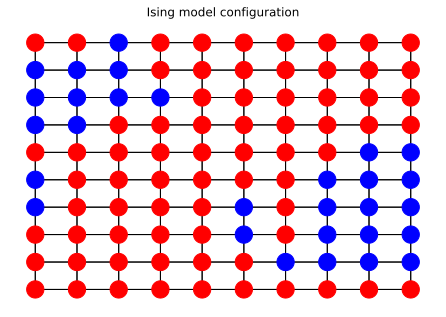

In [109]:
chain.drawConfig(chain.Xmin)

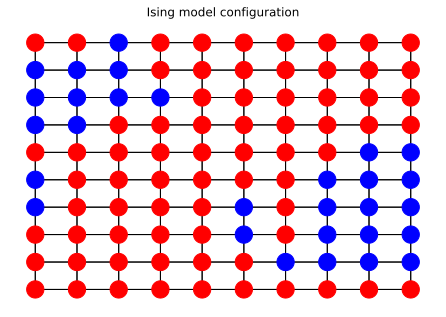

In [110]:
chain.drawConfig(chain.Xmax)

### What do I observe in practice...

In [121]:
L = 10
upper_bound = L**2 * np.log(L)
upper_bound

230.25850929940458

When $\beta = \beta_c / 0.9 > \beta_c$, our algorithm takes somewhere between $2^{17} = 131072$ and $2^{18} = 262124$ steps.  Since the theoretical upper bound $O(n^2 \log n) = O(230)$ is not super informative with the freedom of a perhaps large constant factor at the front, but we see roughly that the algorithm does not run as worse as in exponential time in $|V| = n^2$ and instead runs more efficiently even when $\beta > \beta_c$.